In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline

import seaborn as sns
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3})
sns.set_style('ticks',
              {'grid.linestyle': 'none', 'axes.edgecolor': '0',
               'axes.linewidth': 1.2, 'legend.frameon': True,
               'xtick.direction': 'out', 'ytick.direction': 'out',
               'xtick.top': True, 'ytick.right': True,
              })

import sys

In [2]:
from cpymad.madx import Madx

import sixtracklib as stl
import pysixtrack

In [3]:
from scipy.constants import e, m_p, c

from scipy.constants import physical_constants

In [4]:
madx = Madx(stdout=sys.stdout)
madx.options.echo = False
madx.options.warn = True
madx.options.info = True


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.07.00  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2021.05.03               +
  + Execution date: 2021.12.01 18:53:31      +
  ++++++++++++++++++++++++++++++++++++++++++++


In [5]:
madx.call('./SIS100RING_COLD.seq')

++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy
++++++ info: element redefined: driftdummy


In [6]:
nmass = physical_constants['atomic mass constant energy equivalent in MeV'][0] * 1e-3

A = 238
Q = 28

Ekin_per_nucleon = 0.2e9 # in eV

###

mass = A * nmass * 1e9 * e / c**2 # in kg
charge = Q * e # in Coul

Ekin = Ekin_per_nucleon * A
p0c = np.sqrt(Ekin**2 + 2*Ekin*mass/e * c**2) # in eV

Etot = np.sqrt(p0c**2 + (mass/e)**2 * c**4) * 1e-9 # in GeV
p0 = p0c / c * e # in SI units
gamma = np.sqrt(1 + (p0 / (mass * c))**2)
beta = np.sqrt(1 - gamma**-2)

In [7]:
madx.command.beam(particle='ion', mass=A*nmass, charge=Q, energy=Etot)

True

In [8]:
madx.call('./SIS100_VIRTUAL_FAST.str')

In [9]:
madx.use(sequence='sis100ring')

In [10]:
assert madx.command.select(
    flag='MAKETHIN',
    class_='QUADRUPOLE',
    slice_='9',
)

assert madx.command.select(
    flag='MAKETHIN',
    class_='SBEND',
    slice_='9',
)

assert madx.command.makethin(
    makedipedge=True,
    style='teapot',
    sequence='sis100ring',
)

makethin: style chosen : teapot
makethin: slicing sequence : sis100ring


In [11]:
madx.use(sequence='sis100ring')

In [12]:
madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004194486952        15.44047214 

                q1                dq1            betxmax              dxmax 
       18.87929937       -39.95355367        19.60918074        3.094408448 

             dxrms             xcomax             xcorms                 q2 
       1.369016592                  0                  0        18.79928904 

               dq2            betymax              dymax              dyrms 
      -39.77610643        19.69631848                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [24]:
madx.input('''
    eoption, add=false, seed = rand_seed; 
    select, flag=error, clear;
    select, flag=error, pattern=qd11\.\.slice;
    select, flag=error, pattern=qd12\.\.slice;
    '''
)

True

In [63]:
!rm -f err

In [85]:
madx.input('''
EFCOMP, radius=0.04, order=1,  dknr:={0, 0, 0, 1e-4}, dksr={0, 0, 0, 1e-18}; 
!need negligible a4 due to bug in pysixtrack
''')

Replaced field errors for 2980 elements


True

In [86]:
madx.input('ESAVE, file=err;')

True

In [87]:
twiss = madx.twiss();

enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
            1083.6                 -0     0.004194486952        15.44047214 

                q1                dq1            betxmax              dxmax 
       18.87929937       -39.95355367        19.60918074        3.094408448 

             dxrms             xcomax             xcorms                 q2 
       1.369016592                  0                  0        18.79928904 

               dq2            betymax              dymax              dyrms 
      -39.77610643        19.69631848                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            

In [88]:
pysixtrack_elements = pysixtrack.Line.from_madx_sequence(
    madx.sequence.sis100ring, exact_drift=True, apply_madx_errors=True
)

In [89]:
pysixtrack_elements.remove_zero_length_drifts(inplace=True);
pysixtrack_elements.merge_consecutive_drifts(inplace=True);

In [90]:
quads = [el for el, eln in zip(pysixtrack_elements.elements, pysixtrack_elements.element_names) if 'qd' in eln]

In [91]:
quads[0]

Multipole(knl=[0.0, -0.030992659613337747, 0.0, -0.011622247355001655], ksl=[0.0, 0.0, 0.0, -1.1622247355001655e-16], hxl=0.0, hyl=0.0, length=0.13833333333333334)

In [92]:
elements = stl.Elements.from_line(pysixtrack_elements)

In [93]:
# nturns = 2**10
# elements.BeamMonitor(num_stores=nturns);

In [94]:
particles = stl.Particles.from_ref(
    150, p0c=p0c, mass0=A*nmass*1e9, q0=Q)

In [95]:
init_grid = np.linspace(0, 1e-2, 51, endpoint=True)[1:]
particles.x[:50] += init_grid
particles.y[50:100] += init_grid

particles.x[100:150] += 1e-10
particles.y[100:150] += init_grid

In [96]:
trackjob = stl.TrackJob(elements, particles, device=None)

In [97]:
trackjob.track_until(1) #nturns)
trackjob.collect()

In [98]:
def rectify(tune):
    if tune < 0.5:
        return 1 - tune
    return tune

def compute_J(u, up, beta=twiss['betx'][0], alpha=twiss['alfx'][0]):
    a = alpha
    b = beta
    g = (1 + a**2) / b
    
    return 0.5 * (g * u**2 + 2 * a * u * up + b * up**2)

def compute_oneturn_tune(u, up, dp=None, beta=twiss['betx'][0], alpha=twiss['alfx'][0]):
    u = u.astype(float)
    up = up.astype(float)
    if dp is None:
        dp = np.zeros_like(u)
    dp = dp.astype(float)
    
    a = alpha
    b = beta
    g = (1 + a**2) / b
    
    J = compute_J(u, up, b, a)
    
    phi0 = np.angle(
        (u[0] / np.sqrt(b) / np.sqrt(2 * J[0])) +
        1j * ((u[0] * a / np.sqrt(b) + up[0] * np.sqrt(b)) / np.sqrt(2 * J[0]))
    )

    phi1 = np.angle(
        (u[1] / np.sqrt(b) / np.sqrt(2 * J[1])) +
        1j * ((u[1] * a / np.sqrt(b) + up[1] * np.sqrt(b)) / np.sqrt(2 * J[1]))
    )
    
    tunes = list(map(rectify, np.abs(phi1 - phi0) / (2 * np.pi)))
    
    return np.array(tunes)

In [99]:
Qx_x = compute_oneturn_tune(
    np.vstack((init_grid, particles.x[:50])),
    np.vstack((np.zeros(50), particles.px[:50])),
    beta=twiss['betx'][0], alpha=twiss['alfx'][0])
Qx_x

array([0.87929962, 0.87930035, 0.87930158, 0.8793033 , 0.87930551,
       0.87930821, 0.8793114 , 0.87931508, 0.87931925, 0.87932391,
       0.87932907, 0.87933471, 0.87934085, 0.87934747, 0.87935459,
       0.8793622 , 0.8793703 , 0.87937888, 0.87938796, 0.87939754,
       0.8794076 , 0.87941815, 0.87942919, 0.87944073, 0.87945275,
       0.87946527, 0.87947828, 0.87949177, 0.87950576, 0.87952024,
       0.87953521, 0.87955067, 0.87956662, 0.87958306, 0.8796    ,
       0.87961742, 0.87963533, 0.87965374, 0.87967263, 0.87969202,
       0.8797119 , 0.87973226, 0.87975312, 0.87977447, 0.87979631,
       0.87981864, 0.87984146, 0.87986478, 0.87988858, 0.87991287])

In [100]:
Qy_y = compute_oneturn_tune(
    np.vstack((init_grid, particles.y[50:100])),
    np.vstack((np.zeros(50), particles.py[50:100])),
    beta=twiss['bety'][0], alpha=twiss['alfy'][0])
Qy_y

array([0.79928888, 0.79928842, 0.79928765, 0.79928657, 0.79928519,
       0.79928349, 0.79928149, 0.79927918, 0.79927656, 0.79927363,
       0.79927039, 0.79926685, 0.799263  , 0.79925884, 0.79925437,
       0.79924959, 0.79924451, 0.79923911, 0.79923341, 0.7992274 ,
       0.79922109, 0.79921446, 0.79920753, 0.79920028, 0.79919273,
       0.79918488, 0.79917671, 0.79916823, 0.79915945, 0.79915036,
       0.79914096, 0.79913125, 0.79912124, 0.79911091, 0.79910028,
       0.79908934, 0.79907809, 0.79906653, 0.79905467, 0.7990425 ,
       0.79903001, 0.79901722, 0.79900413, 0.79899072, 0.79897701,
       0.79896298, 0.79894865, 0.79893401, 0.79891907, 0.79890381])

In [101]:
Qx_y = compute_oneturn_tune(
    np.vstack((init_grid, particles.x[100:150])),
    np.vstack((np.zeros(50), particles.px[100:150])),
    beta=twiss['betx'][0], alpha=twiss['alfx'][0])
Qx_y

array([0.87929937, 0.87929938, 0.87929939, 0.87929941, 0.87929943,
       0.87929945, 0.87929948, 0.87929952, 0.87929956, 0.8792996 ,
       0.87929965, 0.8792997 , 0.87929976, 0.87929982, 0.87929989,
       0.87929996, 0.87930004, 0.87930012, 0.8793002 , 0.87930029,
       0.87930039, 0.87930049, 0.87930059, 0.8793007 , 0.87930081,
       0.87930093, 0.87930105, 0.87930118, 0.87930131, 0.87930144,
       0.87930158, 0.87930172, 0.87930187, 0.87930203, 0.87930218,
       0.87930234, 0.87930251, 0.87930268, 0.87930285, 0.87930303,
       0.87930322, 0.8793034 , 0.8793036 , 0.87930379, 0.87930399,
       0.8793042 , 0.8793044 , 0.87930462, 0.87930483, 0.87930506])

In [102]:
# for x in trackjob.output.particles[0].x.reshape((nturns, 150)).T[:50]:
#     plt.plot(1 - np.fft.rfftfreq(nturns), np.abs(np.fft.rfft(x)) / max(np.abs(np.fft.rfft(x))))
# plt.xlim(0.87, 0.89)

In [103]:
# for y in trackjob.output.particles[0].y.reshape((nturns, 150)).T[50:100]:
#     plt.plot(1 - np.fft.rfftfreq(nturns), np.abs(np.fft.rfft(y)) / max(np.abs(np.fft.rfft(y))))
# plt.xlim(0.79, 0.81)

In [104]:
Jx = compute_J(init_grid, np.zeros(50), beta=twiss['betx'][0], alpha=twiss['alfx'][0])
Jy = compute_J(init_grid, np.zeros(50), beta=twiss['bety'][0], alpha=twiss['alfy'][0])

array([35.3373254 ,  0.87929937])

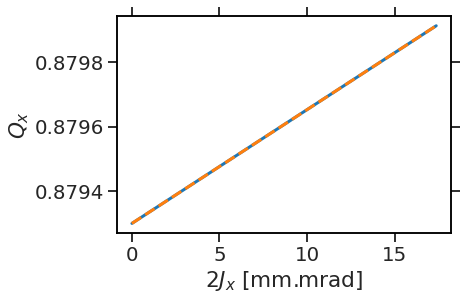

In [105]:
plt.plot(2 * Jx * 1e6, Qx_x)
fit = np.polyfit(2 * Jx, Qx_x, deg=1)
plt.plot(2 * Jx * 1e6, np.poly1d(fit)(2 * Jx), ls='--')
plt.ticklabel_format(style='plain')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('$2J_x$ [mm.mrad]')
plt.ylabel('$Q_x$')
fit

array([-22.40058187,   0.79928904])

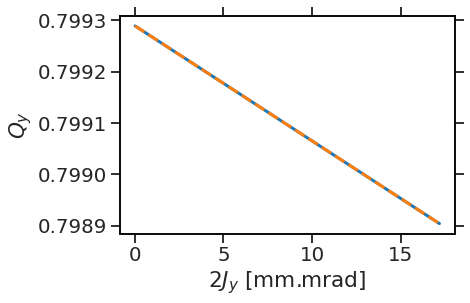

In [106]:
plt.plot(2 * Jy * 1e6, Qy_y)
fit = np.polyfit(2 * Jy, Qy_y, deg=1)
plt.plot(2 * Jy * 1e6, np.poly1d(fit)(2 * Jy), ls='--')
plt.xlabel('$2J_y$ [mm.mrad]')
plt.ylabel('$Q_y$')
fit

array([0.33129337, 0.87929938])

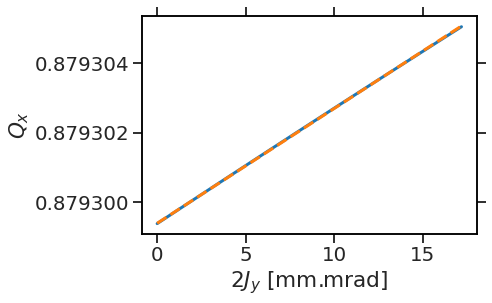

In [107]:
plt.plot(2 * Jy * 1e6, Qx_y)
fit = np.polyfit(2 * Jy, Qx_y, deg=1)
plt.plot(2 * Jy * 1e6, np.poly1d(fit)(2 * Jy), ls='--')
plt.ticklabel_format(style='plain')
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.xlabel('$2J_y$ [mm.mrad]')
plt.ylabel('$Q_x$')
fit